# DEA CoastLines vector statistics

## Background


## Description



## Getting started


### Load packages

First we import the required Python packages, then we connect to the database, and load the catalog of virtual products.

In [1]:
%matplotlib inline
%load_ext line_profiler
%load_ext autoreload
%autoreload 2

import deacoastlines_statistics as dcl_stats

import os
import sys
import geopandas as gpd
from shapely.geometry import box
from rasterio.transform import array_bounds
import pandas as pd
import shutil
import matplotlib.pyplot as plt

sys.path.append('../Scripts')
from dea_spatialtools import subpixel_contours

## Load in data

In [2]:
# Read in contours
study_area = 5279
output_name = 'v0.2.0'
water_index = 'mndwi'
index_threshold = 0.00
baseline_year = '2018'


## Load DEA CoastLines rasters

In [3]:
yearly_ds = dcl_stats.load_rasters(output_name, study_area, water_index)
print(yearly_ds)

# Create output vector folder
output_dir = f'output_data/{study_area}_{output_name}/vectors'
os.makedirs(f'{output_dir}/shapefiles', exist_ok=True)

<xarray.Dataset>
Dimensions:         (x: 2000, y: 2063, year: 31)
Coordinates:
  * y               (y) float64 -3.838e+06 -3.838e+06 ... -3.899e+06 -3.899e+06
  * x               (x) float64 6.725e+05 6.725e+05 ... 7.324e+05 7.325e+05
  * year            (year) int64 1988 1989 1990 1991 ... 2015 2016 2017 2018
Data variables:
    mndwi           (year, y, x) float32 0.5892079 0.56720513 ... 0.4698276
    gapfill_index   (year, y, x) float32 0.51291513 0.4388489 ... 0.48661447
    gapfill_tide_m  (year, y, x) float32 -0.066261284 ... -0.07099597
    gapfill_count   (year, y, x) int16 23 23 23 23 24 24 ... 24 23 23 23 24 24
    stdev           (year, y, x) float32 0.30018646 0.33937132 ... 0.24456586
    tide_m          (year, y, x) float32 -0.05977443 ... -0.05562309
    count           (year, y, x) int16 8 8 8 8 9 9 8 9 10 ... 7 8 8 9 8 8 8 9 9
Attributes:
    crs:        +init=epsg:32653
    transform:  | 30.00, 0.00, 672495.00|\n| 0.00,-30.00,-3837555.00|\n| 0.00...


## Load vector data

In [4]:
# Get bounding box to load data for
bbox = gpd.GeoSeries(box(*array_bounds(height=yearly_ds.sizes['y'],
                                       width=yearly_ds.sizes['x'],
                                       transform=yearly_ds.transform)),
                     crs=yearly_ds.crs)

# Rocky shore mask
smartline_gdf = (gpd.read_file('input_data/Smartline.gdb', 
                               bbox=bbox).to_crs(yearly_ds.crs))

# Tide points
points_gdf = (gpd.read_file('input_data/tide_points_coastal.geojson', 
                            bbox=bbox).to_crs(yearly_ds.crs))

# Study area polygon
comp_gdf = (gpd.read_file('input_data/50km_albers_grid.shp', bbox=bbox)
            .set_index('id')
            .to_crs(str(yearly_ds.crs)))

# Mask to study area
study_area_poly = comp_gdf.loc[study_area]

# Load climate indices
climate_df = pd.read_csv('input_data/climate_indices.csv', index_col='year')

## Extract shoreline contours

### Extract ocean-masked contours

In [16]:
# Generate waterbody mask
waterbody_array = dcl_stats.waterbody_mask(
    input_data='input_data/SurfaceHydrologyPolygonsRegional.gdb',
    modification_data='input_data/estuary_mask_modifications.geojson',
    bbox=bbox,
    yearly_ds=yearly_ds)

In [ ]:
# Mask dataset to focus on coastal zone only
masked_ds = dcl_stats.contours_preprocess(
    yearly_ds,
    water_index,
    index_threshold,
    waterbody_array,
    points_gdf,
    output_path=f'output_data/{study_area}_{output_name}')

In [ ]:
# Extract contours
contours_gdf = subpixel_contours(da=masked_ds,
                                 z_values=index_threshold,
                                 min_vertices=30,
                                 dim='year',
                                 output_path='temp.geojson').set_index('year')

## Compute statistics
### Create stats points on baseline contour

In [ ]:
# Extract statistics modelling points along baseline contour
points_gdf = dcl_stats.stats_points(contours_gdf, baseline_year, distance=30)

# Clip to remove rocky shoreline points
points_gdf = dcl_stats.rocky_shores_clip(points_gdf, smartline_gdf, buffer=50)


### Measure annual coastline movements

In [ ]:
if points_gdf is not None:
    
    # Make a copy of the points GeoDataFrame to hold tidal data
    tide_points_gdf = points_gdf.copy()

    # Calculate annual movements and residual tide heights for every contour
    # compared to the baseline year
    points_gdf, tide_points_gdf = dcl_stats.annual_movements(yearly_ds, 
                                                             points_gdf, 
                                                             tide_points_gdf, 
                                                             contours_gdf, 
                                                             baseline_year,
                                                             water_index)

### Calculate regressions

In [ ]:
if points_gdf is not None:

    points_gdf = dcl_stats.calculate_regressions(yearly_ds, 
                                                 points_gdf, 
                                                 tide_points_gdf, 
                                                 climate_df)

## Export files

### Export stats files

In [ ]:
if points_gdf is not None:

    # Clip stats to study area extent, remove rocky shores
    stats_path = f'{output_dir}/stats_{study_area}_{output_name}_{water_index}_{index_threshold:.2f}'
    points_gdf = points_gdf[points_gdf.intersects(study_area_poly['geometry'])]

    # Export to GeoJSON
    points_gdf.to_crs('EPSG:4326').to_file(f'{stats_path}.geojson', 
                                           driver='GeoJSON')

    # Export as ESRI shapefiles
    stats_path = stats_path.replace('vectors', 'vectors/shapefiles')
    points_gdf.to_file(f'{stats_path}.shp')

### Export contours

In [ ]:
# Assign certainty to contours based on underlying masks
contours_gdf = dcl_stats.contour_certainty(contours_gdf, 
                                           output_path=f'output_data/{study_area}_{output_name}')

# Clip annual shoreline contours to study area extent
contour_path = f'{output_dir}/contours_{study_area}_{output_name}_{water_index}_{index_threshold:.2f}'
contours_gdf['geometry'] = contours_gdf.intersection(study_area_poly['geometry'])
contours_gdf.reset_index().to_crs('EPSG:4326').to_file(f'{contour_path}.geojson', 
                                                       driver='GeoJSON')

# Export stats and contours as ESRI shapefiles
contour_path = contour_path.replace('vectors', 'vectors/shapefiles')
contours_gdf.reset_index().to_file(f'{contour_path}.shp')

### Copy all GeoJSON to folder

In [ ]:
!find /g/data/r78/rt1527/dea-notebooks/MAHTS/output_data/ -type f -path '*_refactor/vectors/*geojson' -exec cp -u '{}' /g/data/r78/rt1527/dea-notebooks/MAHTS/output_data/geojson/ ';'

In [ ]:
!find /g/data/r78/rt1527/dea-notebooks/MAHTS/output_data/ -type f -path '*ntwa/all_time_mask.tif' -exec cp -u '{}' /g/data/r78/rt1527/dea-notebooks/MAHTS/output_data/geojson/ ';'

### Merge GeoJSON

In [ ]:
import glob
glob.glob('output_data/*/vectors/shapefiles/contours_*_ntwa_mndwi_0.00.shp')[0:5]

In [19]:
!ogrmerge.py -o DEACoastLines_coastlines_v0.2.0.shp output_data/*/vectors/shapefiles/contours_*_v0.2.0_mndwi_0.00.shp -single -overwrite_ds

In [20]:
!ogrmerge.py -o DEACoastLines_statistics_v0.2.0.shp output_data/*/vectors/shapefiles/stats_*_v0.2.0_mndwi_0.00.shp -single -overwrite_ds

In [18]:
!gdalwarp output_data/*v0.2.0/all_time_mask.tif mask_v0.2.0_50.tif -co COMPRESS=DEFLATE -co ZLEVEL=9 -co PREDICTOR=1 -co TILED=YES -co BLOCKXSIZE=1024 -co BLOCKYSIZE=1024

Creating output file that is 61846P x 52351L.
Processing output_data/3741_v0.2.0/all_time_mask.tif [1/166] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Processing output_data/3742_v0.2.0/all_time_mask.tif [2/166] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Processing output_data/3843_v0.2.0/all_time_mask.tif [3/166] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Processing output_data/3844_v0.2.0/all_time_mask.tif [4/166] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Processing output_data/3945_v0.2.0/all_time_mask.tif [5/166] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Processing output_data/3946_v0.2.0/all_time_mask.tif [6/166] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Processing output_data/4047_v0.2.0/all_time_mask.tif [7/166] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Processing output_data/4048_v0.2.0/all_time_mask.tif [8/166] : 0...10...20...30...40..

In [ ]:
summary_gdf = dcl_stats.stats_points(contours_gdf, '2018', distance=2000)

In [ ]:
summary_gdf.plot()

In [ ]:



distance = 5000

# Set annual shoreline to use as a baseline
baseline_contour = contours_gdf.loc[['2018']].geometry

# # If multiple features are returned, take unary union
if baseline_contour.shape[0] > 0:
    baseline_contour = baseline_contour.unary_union
else:
    baseline_contour = baseline_contour.iloc[0]

# Generate points along line and convert to geopandas.GeoDataFrame
points_line = [baseline_contour.interpolate(i) 
               for i in range(0, int(baseline_contour.length), distance)]
points_gdf = gpd.GeoDataFrame(geometry=points_line, crs=contours_gdf.crs)


In [ ]:
points_test = points_gdf.head(100)
points_test['geometry'] = points_test.buffer(10000)
points_test.plot()

## Generate continental summary layer

In [277]:
from rtree import index
from tqdm.auto import tqdm

def points_in_poly(points, polygons):

    # Create the R-tree index and store the features in it (bounding box)   
    idx = index.Index()
    for pos, poly in enumerate(tqdm(polygons, desc='Building index')):
        idx.insert(pos, poly.bounds)

    # Iterate through points
    out_dict = {}
    for i, point in enumerate(tqdm(points, desc='Processing points')):

        poly_ids = [j for j in idx.intersection((point.coords[0]))
                    if point.within(polygons[j])]

        out_dict[i] = poly_ids

#     # Re-order output dictionary
#     poly_points_dict = {}
#     for point_id, poly_ids in out_dict.items():
#         for poly_id in poly_ids:
#             poly_points_dict.setdefault(poly_id, []).append(point_id)
    
    return out_dict


def get_matching_data(key, min_n=50):

    matching_points = stats_gdf.iloc[poly_points_dict[key]].copy()

    if len(matching_points.index) > min_n:

        # Set nonsignificant to 0
        matching_points.loc[matching_points.sig_time > 0.01, 'rate_time'] = 0

        return pd.Series([matching_points.rate_time.mean(),
                          len(matching_points.index)])

    else:
        return pd.Series([None, None])

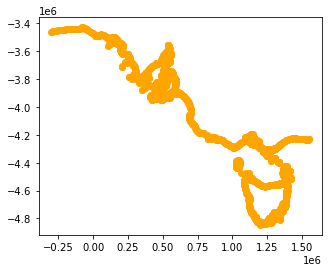

In [199]:
# id_val = '6103'
# stats_gdf = gpd.read_file(f'output_data/{id_val}_v0.2.0/vectors/shapefiles/stats_{id_val}_v0.2.0_mndwi_0.00.shp').to_crs('EPSG:3577')
# contours_gdf = gpd.read_file(f'output_data/{id_val}_v0.2.0/vectors/shapefiles/contours_{id_val}_v0.2.0_mndwi_0.00.shp')

stats_gdf = gpd.read_file(f'DEACoastLines_statistics_v0.2.0.shp').to_crs('EPSG:3577')
contours_gdf = gpd.read_file(f'DEACoastLines_coastlines_v0.2.0.shp')


contours_gdf = (contours_gdf
                .loc[contours_gdf.geometry.is_valid]
                .to_crs('EPSG:3577')
                .set_index('year'))

summary_gdf = dcl_stats.stats_points(contours_gdf, baseline_year='2018', distance=5000)
summary_gdf.plot(c='orange')

In [264]:
# Generate dictionary of polygon IDs and corresponding points
poly_points_dict = points_in_poly(points=summary_gdf.geometry, 
                                  polygons=stats_gdf.buffer(10000))

# Compute mean and number of obs for each polygon
summary_gdf[['rate_time', 'n']] = summary_gdf.apply(
    lambda row: get_matching_data(row.name), axis=1)

# Export to file
summary_gdf.to_file('DEACoastLines_summary_v0.2.0.shp')

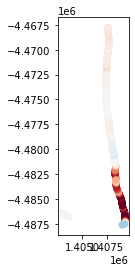

In [276]:
# Plot single summary point data
stats_gdf.iloc[poly_points_dict[819]].plot(column='rate_time', cmap='RdBu', vmin=-5, vmax=5 )

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** April 2020